In [1]:
using PauliPropagation
using Plots
using Printf
using LinearAlgebra
using LaTeXStrings
using ProgressMeter
using Statistics
using StatsBase

In [2]:
function getnewimaginarypaulistring(gate::MaskedPauliRotation, pstr::PauliStringType)
    new_pstr, sign = pauliprod(gate.generator_mask, pstr, gate.qinds)
    return new_pstr, -1im * sign
end


function PauliPropagation.applytoall!(gate::PauliRotation, theta::ComplexF64, psum, aux_psum; kwargs...)
    # NOTE: This is for imaginary time evolution!
    if real(theta) > 0.0
        throw(ArgumentError("Parameter `theta` needs to be fully imaginary. Got theta=$theta"))
    end

    
    # turn the PauliRotation gate into a MaskedPauliRotation gate
    # this allows for faster operations
    gate = PauliPropagation._tomaskedpaulirotation(gate, paulitype(psum))

    # pre-compute the sinh and cosh values because they are used for every Pauli string that does not commute with the gate
    cosh_val = cos(theta)
    sinh_val = sin(theta)
    # loop over all Pauli strings and their coefficients in the Pauli sum
    for (pstr, coeff) in psum

        if !commutes(gate, pstr)
            # if the gate does not commute with the pauli string, do nothing
            continue
        end

        # else we know the gate will split the Pauli string into two
        coeff1 = real(coeff * cosh_val)
        new_pstr, sign = getnewimaginarypaulistring(gate, pstr)
        coeff2 = real(coeff * sinh_val * sign)

        # set the coefficient of the original Pauli string
        set!(psum, pstr, coeff1)

        # set the coefficient of the new Pauli string in the aux_psum
        # we can set the coefficient because PauliRotations create non-overlapping new Pauli strings
        set!(aux_psum, new_pstr, coeff2)
    end

    return
end


function PauliPropagation.applymergetruncate!(gate, psum, aux_psum, thetas, param_idx; max_weight=Inf, min_abs_coeff=1e-10, max_freq=Inf, max_sins=Inf, customtruncfunc=nothing, normalization=false, kwargs...)

    # Pick out the next theta if gate is a ParametrizedGate.
    # Else set the paramter to nothing for clarity that theta is not used.
    if gate isa ParametrizedGate
        theta = thetas[param_idx]
        # If the gate is parametrized, decrement theta index by one.
        param_idx -= 1
    else
        theta = nothing
    end
    # Apply the gate to all Pauli strings in psum, potentially writing into auxillary aux_psum in the process.
    # The pauli sums will be changed in-place
    applytoall!(gate, theta, psum, aux_psum; kwargs...)
    
    # Any contents of psum and aux_psum are merged into the larger of the two, which is returned as psum.
    # The other is emptied and returned as aux_psum.
    psum, aux_psum = mergeandempty!(psum, aux_psum)

    nq = psum.nqubits    
    if normalization
        min_abs_coeff = min_abs_coeff * getcoeff(psum, :I, 1)
    end
    
    # Check truncation conditions on all Pauli strings in psum and remove them if they are truncated.
    PauliPropagation.checktruncationonall!(psum; max_weight, min_abs_coeff, max_freq, max_sins, customtruncfunc)

    return psum, aux_psum, param_idx
end

In [3]:
function createMaxWeightRandomPauli(nq::Int)
    symbols = Symbol[]
    for i in 1:nq
        push!(symbols, rand([:X, :Y, :Z]))
    end
    return symbols
end

createMaxWeightRandomPauli (generic function with 1 method)

In [4]:
function thermalStateWeightsEvolution(circuit, nl, nq, pstr; max_weight=nq, min_abs_coeff=0)

    psum = PauliSum(pstr)
    psum = propagate!(circuit, psum; max_weight, min_abs_coeff, normalization=false)
    weight = countweight(psum)
    weightAvg = mean(weight)    
    return weightAvg
end

thermalStateWeightsEvolution (generic function with 1 method)

In [5]:
theta = 0.01im
θ = theta
nq = 20

topology = bricklayertopology(nq)

# the circuit
circuit = Gate[]
nl = 1
for i in 1:nl
    #append!(circuit, PauliRotation(:X, ii, θ) for ii in 1:nq);
    append!(circuit, PauliRotation(:Z, ii, θ) for ii in 1:nq);
    append!(circuit, PauliRotation([:X, :X], pair, θ) for pair in topology);
end

Progress: 100%|█████████████████████████████████████████| Time: 0:09:05


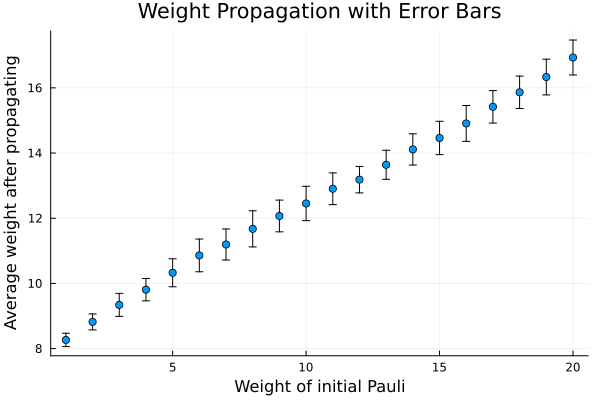

In [6]:
nl = 1
samples = 100
size = 1:nq
means = []
variances =[]
@showprogress for i in size
    weights = []
    for j in 1:samples
        index = sample(1:nq, i; replace=false)
        # create a random Pauli string
        symbols = createMaxWeightRandomPauli(i)
        pstr = PauliString(nq, symbols, index)

        # calculate the weights
        weight = thermalStateWeightsEvolution(circuit, nl, nq, pstr; min_abs_coeff=1e-12)
        push!(weights, weight)
    end
    push!(means, mean(weights))
    push!(variances, var(weights))
end
plot(
    size,
    means,
    yerror=sqrt.(variances),  
    xlabel="Weight of initial Pauli",
    ylabel="Average weight after propagating",
    title="Weight Propagation",
    legend=false,
    seriestype=:scatter,  
    markershape=:circle
)

In [12]:
theta = 0.01im
θ = theta
nq = 20

topology = bricklayertopology(nq)

# the circuit
circuit = Gate[]
nl = 1
for i in 1:nl
    append!(circuit, PauliRotation([:X, :X], pair, θ) for pair in topology);
    append!(circuit, PauliRotation([:Y, :Y], pair, θ) for pair in topology);
    append!(circuit, PauliRotation([:Z, :Z], pair, θ) for pair in topology);
end

Progress: 100%|█████████████████████████████████████████| Time: 0:27:10


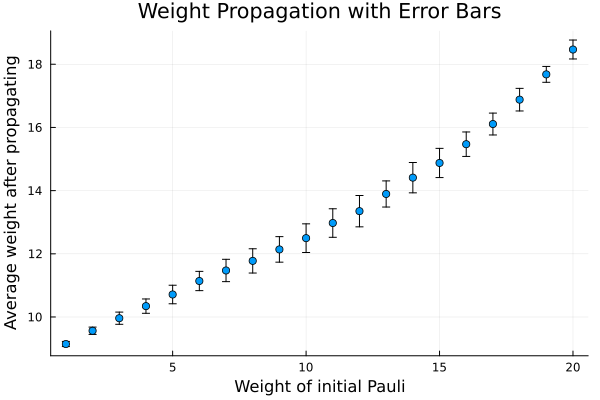

In [13]:
nl = 1
samples = 100
size = 1:nq
means = []
variances =[]
@showprogress for i in size
    weights = []
    for j in 1:samples
        index = sample(1:nq, i; replace=false)
        # create a random Pauli string
        symbols = createMaxWeightRandomPauli(i)
        pstr = PauliString(nq, symbols, index)

        # calculate the weights
        weight = thermalStateWeightsEvolution(circuit, nl, nq, pstr; min_abs_coeff=1e-12)
        push!(weights, weight)
    end
    push!(means, mean(weights))
    push!(variances, var(weights))
end
plot(
    size,
    means,
    yerror=sqrt.(variances),  
    xlabel="Weight of initial Pauli",
    ylabel="Average weight after propagating",
    title="Weight Propagation",
    legend=false,
    seriestype=:scatter,  
    markershape=:circle
)